In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import fuzzywuzzy as fuzz


## A. (Suggested duration: 90 mins)
With the given data for 548552 products, perform exploratory analysis and make
suggestions for further analysis on the following aspects.

In [2]:
categories = pd.read_csv('categories.csv', encoding = "ISO-8859-1")
reviews = pd.read_csv('reviews.csv', encoding = "ISO-8859-1")
reviews['helpfulness'] = reviews['HELPFUL']/reviews['VOTES']

reviews = reviews.drop('Unnamed: 0', 1)
categories = categories.drop('Unnamed: 0', 1)


In [3]:
rank_group = pd.read_csv('rank_and_group.csv', encoding = "ISO-8859-1")
rank_group = rank_group.set_index('ID')
similiar = pd.read_csv('similar.csv', encoding = "ISO-8859-1")
rank_group.loc[rank_group['rank']<=0,"rank"] = 0 #fix < 1

## A1. Trustworthiness of ratings
Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively
speaking) about the ratings in this dataset?


### Create Pivot for Rating Summary

In [4]:
run = 0
if run == 1:
    df_rating_summary = reviews.pivot_table(index = "PROD_ID", values = ['RATING','helpfulness'], aggfunc = [np.mean,len])
    df_rating_summary.columns = ['mean_rating','mean_helpfulness','ct_rating','ct_helpful']
    df_rating_summary = df_rating_summary.drop("ct_helpful",1)
    df_rating_summary = df_rating_summary.merge(rank_group, left_index = True, right_index = True)
    df_rating_summary = df_rating_summary.dropna()
    df_rating_summary = df_rating_summary[df_rating_summary.group.isin(['Book','DVD','Music','Video'])] # Remove Low Frequency
    df_rating_summary.to_csv("rating_summary.csv", index = False)
else:
    df_rating_summary = pd.read_csv("rating_summary.csv")


## Exploratory Data Analysis

Group Count

In [5]:
to_plot = df_rating_summary
to_plot.groupby('group')['mean_rating','mean_helpfulness'].size()

group
Book     268190
DVD       18249
Music     79630
Video     21911
dtype: int64

##### PairPlot: Scatter Matrix on Key Variables
- High frequency in high and helpful ratings for books and music -- might signal that these are genres where there are a lot of 
interest where some proprtion is driven by bias
- Almost "bimodal" nature in ratings vs rank and helpfulness vs rank:
    - Books: Lots of extreme ratings
- More ratings seen a helpfuless rating reach .5 (conical shape)


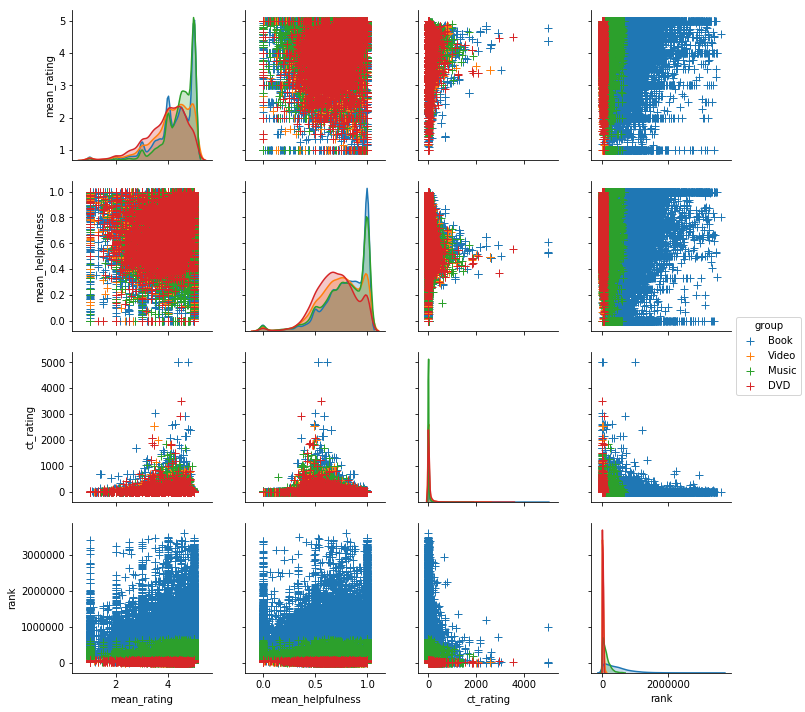

In [6]:
to_plot = df_rating_summary.sample(100000)
sns.pairplot(to_plot, diag_kind="kde", markers="+",hue="group",
             plot_kws=dict(s=50, edgecolor="b", linewidth=1),
             diag_kws=dict(shade=True))

#### Sales Rank vs Helpfulness and Ratings

Helpfulness is defined as (# Voted Helpful) / (Total Votes). The data below are binned into 30 "rank" buckets. 

Looking at books, we can see that as rank increases, the helpfulness of ratings deteriorate. This signals potentially bad / bias reviews. In addition, the sales rank increases also are associated with reduction of rating.

Music interstingly sees a dip on both sides suggesting that helpfuless for high and low ranking sales are associated with bad / bias reviews. Interestingly, both sides show a high rating. This is an area for investigation. For example, I would suggesting investigting the type of individuals who rate these -- do we seem them rating similarly in other ranking bins?

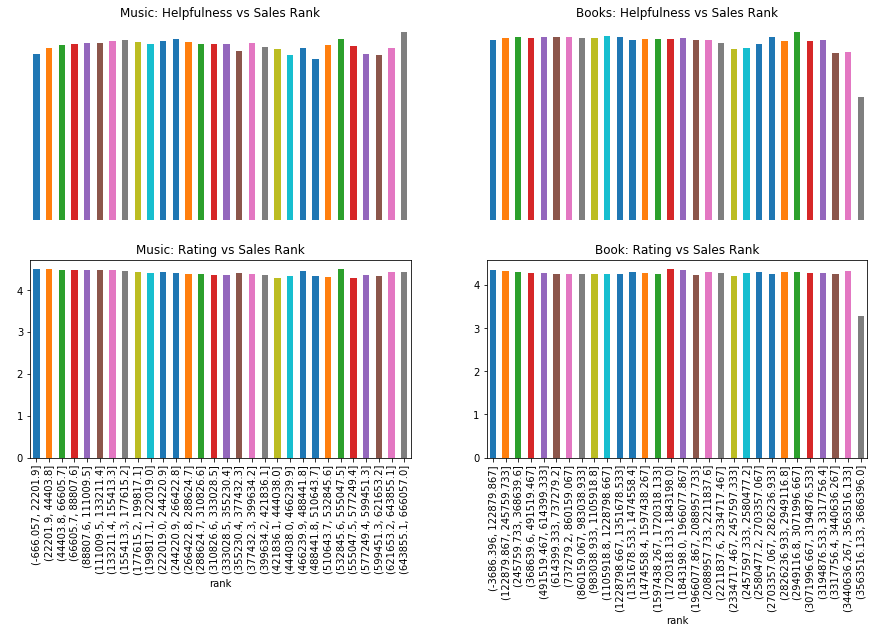

In [7]:
plt.figure(figsize = (15,8))
plt.subplot(2,2,1)
bars_1 = df_rating_summary[df_rating_summary.group == 'Music'].sort_values('rank', ascending = False)[['rank','mean_helpfulness','mean_rating','group']]
bars_1['rank'] = pd.cut(bars_1['rank'], 30)
bars_1.groupby('rank')['mean_helpfulness'].mean().plot(kind = 'bar')
plt.axis('off')
plt.title('Music: Helpfulness vs Sales Rank')

plt.subplot(2,2,2)
bars_2 = df_rating_summary[df_rating_summary.group == 'Book'].sort_values('rank', ascending = False)[['rank','mean_helpfulness','mean_rating','group']]
bars_2['rank'] = pd.cut(bars_2['rank'], 30)
bars_2.groupby('rank')['mean_helpfulness'].mean().plot(kind = 'bar')
plt.axis('off')
plt.title('Books: Helpfulness vs Sales Rank')

plt.subplot(2,2,3)
bars_1 = df_rating_summary[df_rating_summary.group == 'Music'].sort_values('rank', ascending = False)[['rank','mean_helpfulness','mean_rating','group']]
bars_1['rank'] = pd.cut(bars_1['rank'], 30)
bars_1.groupby('rank')['mean_rating'].mean().plot(kind = 'bar')
plt.title('Music: Rating vs Sales Rank')

plt.subplot(2,2,4)
bars_1 = df_rating_summary[df_rating_summary.group == 'Book'].sort_values('rank', ascending = False)[['rank','mean_helpfulness','mean_rating','group']]
bars_1['rank'] = pd.cut(bars_1['rank'], 30)
bars_1.groupby('rank')['mean_rating'].mean().plot(kind = 'bar')
plt.title('Book: Rating vs Sales Rank')

plt.show()

## A2. Category bloat
Consider the product group named 'Books'. Each product in this group is associated with
categories. Naturally, with categorization, there are tradeoffs between how broad or
specific the categories must be.

For this dataset, quantify the following:


**
a. Is there redundancy in the categorization? How can it be identified/removed?
**
Below, I write some sample code for 1000 categorizations.. If we run a correlation matrix and select a high threshold, this can be one way of identifying highly correlated categories. Those that are highly correlatd can then be grouped together or removed. 

** 
b. Is is possible to reduce the number of categories drastically (say to 10% of existing
categories) by sacrificing relatively few category entries (say close to 10%)?
**
I believe the approach here is to identify categorys that have relatively few entries. The business rule here, would be to identify a threshold of specificity. For example Fiction is not very specific, removing this would sacrifice many. While, Joan Didion is very specific and removing would affect fewer products. So, I believe the task to be identifying overlyspecific and rare categories. This is done in Section 2b's code chunk.

Using the above logic, a 90% reduction of categories will result in entry loss of roughly 28%. **A better threshold would be at 75% reduction, which would give us about 10% loss.**



### 2A

In [81]:
book_prod_ids = categories.query('DESC == "Books"').PROD_ID.unique()
book_cats = categories[categories.PROD_ID.isin(book_prod_ids)]
# test code, work with a chunk. Get prod_id withi 10000 
sample_these = book_cats.PROD_ID.sample(100000).head(10000)
test_these = book_cats[book_cats.PROD_ID.isin(sample_these)]
# build codes from products
cat_combo = test_these.groupby(['PROD_ID','TBL_ID'])["CAT_CODE"].apply(lambda x: '.'.join(x.astype(str)))
desc_combo = test_these.groupby(['PROD_ID','TBL_ID'])["DESC"].apply(lambda x: '.'.join(x.astype(str)))
# Make DF
cat_combo = pd.DataFrame(cat_combo)
desc_combo = pd.DataFrame(desc_combo)
# Join DFs
cluster_frame = cat_combo.merge(desc_combo, left_index= True, right_index=True)
cluster_frame.columns = ['cat_code','desc']
# Get unique values to recode
unq_codes =cluster_frame.cat_code.unique()
recode_frame = pd.DataFrame({'cat_code':unq_codes,'recode_cat':['code_' + str(i) for i in np.arange(0, len(unq_codes))]})
cluster_frame = cluster_frame.reset_index().merge(recode_frame)
cluster_frame = cluster_frame.pivot_table(index = 'PROD_ID', columns = 'recode_cat',values = 'cat_code',aggfunc=len).fillna(0)
corrd = cluster_frame.corr()
corrd = np.tril(np.ones(corrd.shape))*corrd
corr_frame = pd.DataFrame(corrd.unstack(), columns=['correlation'])
corr_frame.index.names = ['var_1','var_2']
corr_frame = corr_frame.reset_index()
high_corr = corr_frame.query('(var_1 != var_2) & correlation >.9')
print('there are ', len(high_corr), 'Highly correlated values')
high_corr.head().append(high_corr.tail())

there are  7846 Highly correlated values


,var_1,var_2,correlation
12786,code_10,code_12,0.929850
18879,code_100,code_103,1.000000
56539,code_1005,code_1006,1.000000
75385,code_1008,code_1009,1.000000
94231,code_1010,code_1011,1.000000
38847891,code_911,code_914,0.948538
38929555,code_923,code_924,1.000000
39105453,code_949,code_951,1.000000
39205964,code_963,code_965,1.000000
39369295,code_987,code_988,0.985963


### 2B

In [110]:
book_prod_ids = categories.query('DESC == "Books"').PROD_ID.unique()
book_cats = categories[categories.PROD_ID.isin(book_prod_ids)]
book_cats = book_cats.groupby(['PROD_ID','TBL_ID'])["DESC"].apply(lambda x: '.'.join(x.astype(str)))
sorted_books = book_cats.reset_index().groupby('DESC').size().sort_values()
print("10% of", len(book_prod_ids), 'is :',round(len(book_prod_ids)*.01))

10% of 331679 is : 3317


In [295]:
book_ct_frame = pd.DataFrame(
    {'RecordFrequency':sorted_books,
     'RollingFrequency':sorted_books.cumsum(),
     "Cat_Ct":(np.arange(1,len(sorted_books)+1))
    }
)

book_ct_frame['Perc_of_Cats'] = book_ct_frame['Cat_Ct']/len(sorted_books)*100
book_ct_frame['Perc_of_Entries'] = (book_ct_frame['RollingFrequency']/book_ct_frame.RecordFrequency.sum())*100
book_ct_frame.query("Perc_of_Cats >89.99 & Perc_of_Cats <90.0001").head()

,Cat_Ct,RecordFrequency,RollingFrequency,Perc_of_Cats,Perc_of_Entries
DESC,,,,,
Books.Formats.Libros en espaÃ±ol.ReligiÃ³n y espiritualidad,10865,194,299286,89.994202,28.081458


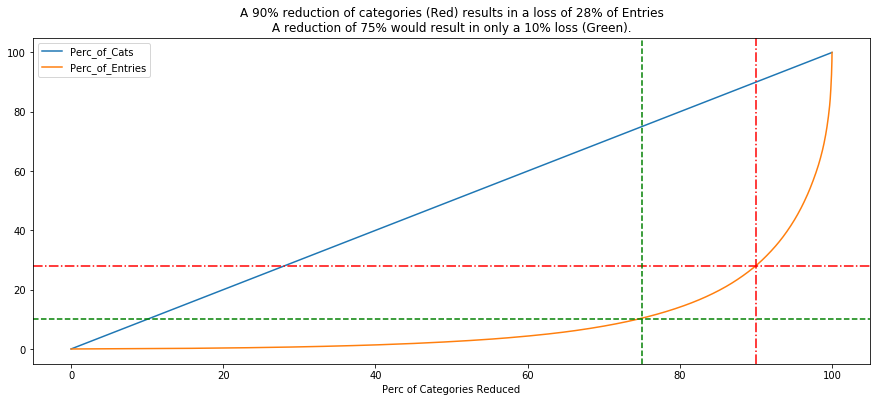

In [294]:
book_ct_frame['Perc of Categories Reduced'] = book_ct_frame.Perc_of_Cats
book_ct_frame.set_index('Perc of Categories Reduced').iloc[:,3:5].plot(figsize = (15,6), 
                                                       title = 
                                                       'A 90% reduction of categories (Red) results in a loss of 28% of Entries\n A reduction of 75% would result in only a 10% loss (Green). ')
plt.axvline(x= 90, c = 'red',linestyle = '-.')
plt.axhline(y = 28, c = 'red', linestyle = '-.')

plt.axhline(y = 10, c = 'green', linestyle = '--')
plt.axvline(x = 75, c = 'green', linestyle = '--')
plt.show()

## B. (Suggested duration: 30 mins)
Give the number crunching a rest! Just think about these problems.

### B1. Algorithm thinking
How would build the product categorization from scratch, using similar/co-purchased
information? 

I would use information about each user (demographic data), then given that two items are similar, users with certain types of preferences will choose one over another. With these two datasets and a large volumne of information, I would identify "scores" for each group of individual. For example, Let's say that our data set has office workers and teachers. And we're selling books. With this data, we might see a large effect in terms of % of office workers buying a certain book that's also statisticall significant. This might mean that this is a office-productivit or professional development book. 

With co purchase information, if we know that office workers tend to purchase professional developbooks and luggages a lot, we can begin to add a finer level of detail by categorizing perhaps creating a category called "readers-on-the-go" if there is a high frequency of those two items being purchased -- where this would depend on a certain model parameter of what constitutes a "high frequency". 

### B2. Product thinking
Now, put on your 'product thinking' hat.

a. Is it a good idea to show users the categorization hierarchy for items?
(Probably not. Some have multiple categorizations. It depends on the accuracy of each categorization. If incorrectly  categorized, it may take the user down the incorrect level. I would perhaps use more general categorization based on a certain frequency cut value. For example in the exercises above we see that there are many category paths that end up having only one value. Perhaps I would cut it so that there is a substantive amount of books in a category. This way users will actually find this useful. An example of a deep category path might be Book / Spiritual / Modern / Early 2000's / West Coast thinkers / Esoteric Thinkers / Black Authors / Authors born in the 1950s / Authors with names starting with "G" / Books by John Doe -- which might be so deep that there's at each level before John Doe, only a few instances are shown. This is potentially overwhelming and complex. I might set up a hierachy to stop when it reaches 3 - 5 levels ensuring a higher but not overwhelming) quantity of results. 

b. Is it a good idea to show users similar/co-purchased items?
Yes. I think this is important as a means of validating methods and categorize users. If a user is new (cold start problem) and only purchases one item, lets called this A, and then does not purchase Item B even though it is highly recommended, this can be a flag for a potential different subset of user -- especially if there are enough people that do not behave as expected. This is a good way to help continuously evolve the understanding of users. In addition, this is helpful as it makes users lives easier using this simple recommendation method. 

c. Is it a good idea to show users reviews and ratings for items?
To a certain degree yes. Ratings and reviews are only useful if we believe that each is genuine and useful, else with manipulated reviews -- user satisifaction will tank. This can be potentially addressed by researching how business write fake reviews (for example, is it some sort of mechanical turk type systems? -- if so use a similar system (given R&D budget) to reproduce a data set of true disingenuous reviews and train a model to classify fake reviews. In addition, add anothe layer such as feedback button such as one that says "Flag this: I think this is fake!". 

If a good set of reviews and ratings arise, this can be very helpful. A balanced approach to promote new items is necessary as well such as new competing products. One way to approach this is to firstly identify which users are most "ratings sensitive" in terms of number of reviews and average review and even further which types of products are purchased at a higher rate because of ratings sensitivity (for example, a really good one-time purchase of an expensive vacuum cleaner would prompt me to read reviews and look at ratings, wherease a toothbrush, may matter less in terms of ratings). Once these are identified, build in some sort of system that promotes new items to users such as a prompt that says, "hey this is a new item on the market, even thought it has not been as reviewed as the current item you're looking at, check it out! you might like it!"

d. For each of the above, why? How will you establish the same? (answered up in each prompt)

